# **Reinforcement Learning (COMP-767) Assignment 2 - Code :Question - 2**
## Student 1:
## Name: Bhavya Patwa
### McGill ID: 260964036
### email ID: bhavya.patwa@mail.mcgill.ca
## Student 2:
## Name: Yifan Bai
### McGill ID: 260562421
### email ID: yifan.bai@mail.mcgill.ca

# **REINFORCE METHOD**

In [0]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm_notebook as tqdm

In [0]:
env = gym.make('CartPole-v0')
env.reset()

array([ 0.02128094,  0.02103189,  0.04743013, -0.00508653])

In [0]:
print(env.action_space,env.observation_space)
print(env.action_space.sample())

Discrete(2) Box(4,)
1


In [0]:
class Reinforce:
  # initializing model and optimizer
  def __init__(self,lr=2e-3,gamma=1):
    self.model = Sequential([
      Dense(100, input_shape=(4,)),
      Dropout(0.2),
      Dense(2,activation='softmax'),
  ])
    # discount rate
    self.gamma = gamma
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    self.reset()

  # reset class variables to store episodic information on new data
  def reset(self):
    self.obs = []
    self.rewards = []
    self.action = []

  # predict action probabilities using policy model
  def predict(self,obs):
    action_probs = self.model.predict(obs)
    return action_probs

  # store S,R,A at timestep t
  def collect_episode_info(self,obs,R,action):
    self.obs.append(obs)
    self.rewards.append(R)
    self.action.append(action)

  # compute G as per the algorithm
  def compute_G(self):
    G = []
    g = 0
    # optimized version which calculates value of G from last time step
    for r in self.rewards[::-1]:
      g = r + self.gamma*g
      G.insert(0,g)
    # print(G)
    return G
  
  # log loss function.
  # "a" is the action taken and "g" is the G at timestep t
  def loss(self,predictions,a,g):
    y = tf.keras.utils.to_categorical(a,num_classes=2)
    softmax = tf.reduce_sum(tf.multiply(predictions,y))
    loss = -K.log(softmax)*g
    return loss

  # gradient update at every timestep t
  @tf.function
  def update(self):
    G = self.compute_G()
    # update gradient for every timestep t
    for i in range(len(self.rewards)):    
      with tf.GradientTape() as tape:
        X = tf.convert_to_tensor(self.obs[i])
        g = G[i]
        predictions = self.model(X, training=True)
        loss = self.loss(predictions,self.action[i],g)
      gradients = tape.gradient(loss, self.model.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.reset()
    

In [0]:
# train on reinforce algorithm
def run(episodes=1000,seed=0):
  env.seed(seed)
  losses = []
  episode_length = []
  average_reward = []
  reinforce_model = Reinforce()
  for i in tqdm(range(episodes)):
      rewards = []
      obs = env.reset()
      for j in range(1000):
        obs = obs.reshape(1,4)
        # predict action probs and sample using it's probablities
        sampled_action = reinforce_model.predict(obs)[0]
        action = np.random.choice(2,p=sampled_action)
        # take action
        next_obs, reward, done, _ = env.step(action) # take a random action
        # store observations, rewards and action
        reinforce_model.collect_episode_info(obs,reward,action)
        if done:
          rewards.append(reward)
          env.reset()
          episode_length.append(j+1)
          break
        obs = next_obs
      # update gradients at the end of each episode
      reinforce_model.update()
      
  return episode_length

In [0]:
seeds = [0,5,11,13,42]
episode_lengths_re = [run(seed=seed,episodes=1000) for seed in seeds]
# print(losses[:10])
# print(losses[-10:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Text(0, 0.5, 'Episode length')

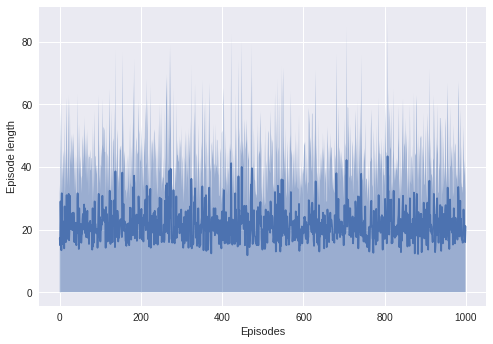

In [0]:
episode_length_re = np.mean(episode_lengths_re,axis=0)
episode_std_re = np.mean(episode_lengths_re,axis=0)
# print(episode_length_re[-10:])
plt.plot(episode_length_re,label='reinforce')
plt.fill_between(list(range(1000)),episode_length_re+episode_std_re,episode_length_re-episode_std_re,alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Episode length')

# **Actor Critic model**

In [0]:
class ActorCritic:
  # initializing model and optimizer for policy and value estimator
  def __init__(self,lr=2e-3,gamma=1):
    self.model_policy = Sequential([
      Dense(128, input_shape=(4,),activation='relu'),
      Dropout(0.3),
      Dense(2,activation='softmax'),
  ])
    self.model_val = Sequential([
      Dense(128, input_shape=(4,)),
      Dropout(0.2),
      Dense(1),
  ])
    self.model_val.compile(optimizer='adam',
              loss='mse')
    self.gamma = gamma # discount factor
    self.optimizer_val = tf.keras.optimizers.Adam(learning_rate=lr)
    self.optimizer_policy = tf.keras.optimizers.Adam(learning_rate=lr)
    self.reset()

  # reset episodic information at the end of each episode
  def reset(self):
    self.obs = []
    self.rewards = []
    self.action = []
    self.delta = None
    self.td_target = None

  # prediction action probabilities using policy estimator
  def predict_policy(self,obs):
    action_probs = self.model_policy.predict(obs)
    return action_probs

  # predict value using value estimator
  def predict_val(self,obs):
    val = self.model_val.predict(obs)
    return val

  # collect episodic information at every time step
  def collect_episode_info(self,obs,R,action):
    self.obs.append(obs)
    self.rewards.append(R)
    self.action.append(action)

  # compute delta (td_error) for policy estimator and td_target for value estimator
  def compute_delta(self,next_state):
    v_s_prime = self.predict_val(next_state)
    v_s = self.predict_val(self.obs[-1])
    td_target = self.rewards[-1] + self.gamma*v_s_prime
    delta = td_target - v_s
    self.delta = delta
    self.td_target = td_target
  
  # loss fn for policy estimator
  # "a" is the action taken
  def loss_policy(self,predictions,a):
    y = tf.keras.utils.to_categorical(a,num_classes=2)
    softmax = tf.reduce_sum(tf.multiply(predictions,y))
    loss = -K.log(softmax)*self.delta
    return loss

  # update fn for policy estimator
  @tf.function
  def update_policy(self):
    with tf.GradientTape() as tape:
      X = tf.convert_to_tensor(self.obs[-1])
      predictions = self.model_policy(X, training=True)
      loss = self.loss_policy(predictions,self.action[-1])
    gradients = tape.gradient(loss, self.model_policy.trainable_variables)
    # print("gradients:",gradients)
    self.optimizer_policy.apply_gradients(zip(gradients, self.model_policy.trainable_variables))
    # return loss

  # UNUSED
  # # update fn for value estimator
  # @tf.function
  # def update_val(self):
  #   with tf.GradientTape() as tape:
  #     X = tf.convert_to_tensor(self.obs[-1])
  #     prediction = self.model_val(X, training=True)
  #     loss = tf.keras.losses.MSE(self.td_target,prediction)
  #   gradients = tape.gradient(loss, self.model_val.trainable_variables)
  #   # print("gradients:",gradients)
  #   self.optimizer_val.apply_gradients(zip(gradients, self.model_val.trainable_variables))

  # update fn that calls update for both policy and value estimators  
  def update(self,next_obs):
    # computes td_error and delta
    self.compute_delta(next_obs)
    # self.update_val()
    self.update_policy()
    self.model_val.fit(self.obs[-1],self.td_target,verbose=0)
    self.reset()

In [0]:
# train on actor critic algorithm
# same procedure as reinforce code
def run_actor_critic(episodes=1000,seed=0):
  env.seed(seed)
  losses = []
  episode_length = []
  average_reward = []
  actor_critic_model = ActorCritic()
  for i in tqdm(range(episodes)):
      rewards = []
      obs = env.reset()
      for j in range(1000):
        obs = obs.reshape(1,4)
        # sampling next action probabilites
        sampled_action = actor_critic_model.predict_policy(obs)[0]
        action = np.random.choice(2,p=sampled_action)
        next_obs, reward, done, _ = env.step(action) # take a random action
        actor_critic_model.collect_episode_info(obs,reward,action)
        actor_critic_model.update(next_obs.reshape(1,4))
        if done:
          rewards.append(reward)
          env.reset()
          episode_length.append(j+1)
          break
        obs = next_obs
  return episode_length

In [0]:
seeds = [0,2,5,13,42]
episode_lengths_ac = [run_actor_critic(seed=seed,episodes=1000) for seed in seeds]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Text(0, 0.5, 'Episode length')

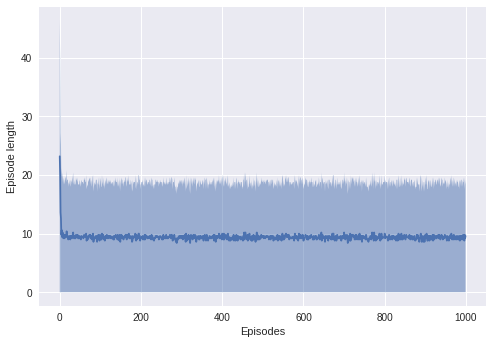

In [0]:
episode_length_ac = np.mean(episode_lengths_ac,axis=0)
episode_std_ac = np.mean(episode_lengths_ac,axis=0)
# print(episode_length_re[-10:])
plt.plot(episode_length_ac,label='actor-critic')
plt.fill_between(list(range(1000)),episode_length_ac+episode_std_ac,episode_length_ac-episode_std_ac,alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Episode length')

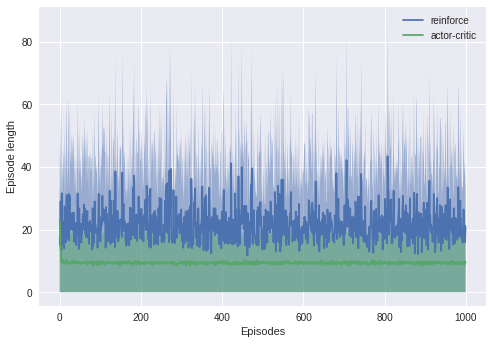

In [0]:
plt.plot(episode_length_re,label='reinforce')
plt.fill_between(list(range(1000)),episode_length_re+episode_std_re,episode_length_re-episode_std_re,alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Episode length')
plt.plot(episode_length_ac,label='actor-critic')
plt.fill_between(list(range(1000)),episode_length_ac+episode_std_ac,episode_length_ac-episode_std_ac,alpha=0.5)
plt.legend(loc="upper right")

## **Observations (Reinforce)**
1. The episode length high varies for each episode
2. Model is finding it hard to converge (>150 episode length), yet is able to reach 50-60 episode length

## **Observations (Actor-critic)**
1. Actor-critic method episode length has non existent variance.
2. Actor-critic model has failed to converge or improve/perform better than reinforce method

Original (reinforce method) time complexity to compute G: $O(n^2)$ 

Time complexity to compute G in our code: $O(n)$
